<a href="https://colab.research.google.com/github/BuddhikaRoshan/HemoAi/blob/Heshani/thalassemia2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
# ========================
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ========================
# Imports
# ========================
import os, glob, pickle, random, shutil
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt


In [ ]:
# ========================
# Config
# ========================
IMG_SIZE = 128
BATCH_SIZE = 16
EPOCHS = 20   # slightly more to allow convergence
MAX_RBC_PER_IMAGE = 25


In [ ]:
# ========================
# Handcrafted Features
# ========================
def target_cell_score(gray):
    h, w = gray.shape
    cx, cy = w//2, h//2
    Y, X = np.ogrid[:h, :w]
    d = np.sqrt((X - cx)**2 + (Y - cy)**2)
    r = np.max(d)
    c = gray[d < r*0.25]
    m = gray[(d >= r*0.25) & (d < r*0.5)]
    o = gray[(d >= r*0.5) & (d < r*0.75)]
    if len(c)==0 or len(m)==0 or len(o)==0:
        return 0
    return (np.mean(m)-np.mean(c)) + (np.mean(m)-np.mean(o))

def blue_ratio(rbc):
    b, g, r = cv2.split(rbc)
    return np.mean(b)/(np.mean(r)+1e-5)

def compute_rbc_features(rbc):
    gray = cv2.cvtColor(rbc, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape
    return [target_cell_score(gray), blue_ratio(rbc), abs(h-w)/max(h,w), h*w]

def label_rbc(rbc):
    t,b,v,a = compute_rbc_features(rbc)
    h,w = cv2.cvtColor(rbc, cv2.COLOR_BGR2GRAY).shape
    if h < 10 or w < 10:
        return "healthy"
    if t > 12 or b > 1.1 or v > 0.4 or a < 300:
        return "likely_thalassemia"
    return "healthy"


In [ ]:
# ========================
# Extract RBCs
# ========================
def extract_rbcs(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5),0)
    _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cells, labels, feats = [], [], []
    for c in contours[:MAX_RBC_PER_IMAGE]:
        if cv2.contourArea(c) < 100: continue
        x,y,w,h = cv2.boundingRect(c)
        rbc = image[y:y+h, x:x+w]
        cells.append(cv2.resize(rbc, (IMG_SIZE, IMG_SIZE)))
        labels.append(label_rbc(rbc))
        feats.append(compute_rbc_features(rbc))
    return cells, labels, feats

# ========================
# Load folder
# ========================
def load_folder(folder_path):
    X, y, feats = [], [], []
    for p in glob.glob(os.path.join(folder_path, '*')):
        img = cv2.imread(p)
        if img is not None:
            c,l,f = extract_rbcs(img)
            X.extend(c); y.extend(l); feats.extend(f)
    return X, y, feats


In [ ]:
# ========================
# Manual train/test paths
# ========================
train_healthy = '/content/drive/MyDrive/new2/training/healthy'
train_affected = '/content/drive/MyDrive/new2/training/affected'
test_healthy = '/content/drive/MyDrive/new2/test/healthy'
test_affected = '/content/drive/MyDrive/new2/test/affected'

# Load training and test sets
X_train_h, y_train_h, f_train_h = load_folder(train_healthy)
X_train_a, y_train_a, f_train_a = load_folder(train_affected)
X_test_h, y_test_h, f_test_h = load_folder(test_healthy)
X_test_a, y_test_a, f_test_a = load_folder(test_affected)


In [ ]:
# ========================
# Oversample affected cells in training
# ========================
oversample_factor = max(1, len(X_train_h)//len(X_train_a))
X_train_a = X_train_a * oversample_factor
y_train_a = y_train_a * oversample_factor
f_train_a = f_train_a * oversample_factor

# Combine healthy + affected
X_train = np.array(X_train_h + X_train_a)
y_train = np.array(y_train_h + y_train_a)
f_train = np.array(f_train_h + f_train_a)

X_test = np.array(X_test_h + X_test_a)
y_test = np.array(y_test_h + y_test_a)
f_test = np.array(f_test_h + f_test_a)

# ========================
# Encode labels & scale features
# ========================
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

scaler = StandardScaler()
f_train = scaler.fit_transform(f_train)
f_test = scaler.transform(f_test)

# Class weights
class_weights = dict(enumerate(
    compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
))

# ========================
# Stronger Data Augmentation
# ========================
augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.15,0.15)
])

In [ ]:
# ========================
# CNN + ViT Model
# ========================
def build_model(num_classes):
    img_in = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    feat_in = layers.Input((4,))
    x = augment(img_in)

    # CNN branch
    base = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=x)
    for layer in base.layers[:-10]:
        layer.trainable = False
    cnn = layers.GlobalAveragePooling2D()(base.output)
    cnn = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(cnn)
    cnn = layers.Dropout(0.3)(cnn)

    # ViT branch
    p = layers.Conv2D(64, 16, strides=16)(x)
    p = layers.Reshape((-1, 64))(p)
    for _ in range(3):
        a = layers.MultiHeadAttention(num_heads=4, key_dim=64)(p, p)
        p = layers.LayerNormalization()(p + a)
        f = layers.Dense(64, activation='relu')(p)
        p = layers.LayerNormalization()(p + f)
    vit = layers.GlobalAveragePooling1D()(p)

    # Fusion
    m = layers.Concatenate()([cnn, vit, feat_in])
    m = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(m)
    m = layers.BatchNormalization()(m)
    m = layers.Dropout(0.4)(m)
    out = layers.Dense(num_classes, activation='softmax')(m)

    model = models.Model([img_in, feat_in], out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )
    return model

model = build_model(len(np.unique(y_train)))
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ sequential[0][0]  │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c

 Total params: 24,016,002 (91.61 MB)

 Trainable params: 4,893,442 (18.67 MB)

 Non-trainable params: 19,122,560 (72.95 MB)

Epoch 1/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.8122 - loss: 0.5566 - val_accuracy: 0.8566 - val_loss: 0.6245
Epoch 2/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.8135 - loss: 0.5449 - val_accuracy: 0.8314 - val_loss: 0.6379
Epoch 3/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.8248 - loss: 0.5263 - val_accuracy: 0.8469 - val_loss: 0.6072
Epoch 4/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.8179 - loss: 0.5373 - val_accuracy: 0.8566 - val_loss: 0.6449
Epoch 5/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.8295 - loss: 0.5153 - val_accuracy: 0.8430 - val_loss: 0.5965
Epoch 6/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.8325 - loss: 0.5179 - val_accuracy: 0.8721 - val_loss: 0.6338
Epoch 7/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.8481 - loss: 0.4968 - val_accuracy: 0.8837 - val_loss: 0.5816
Epoch 8/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.8464 - loss: 0.4867 - val_ac

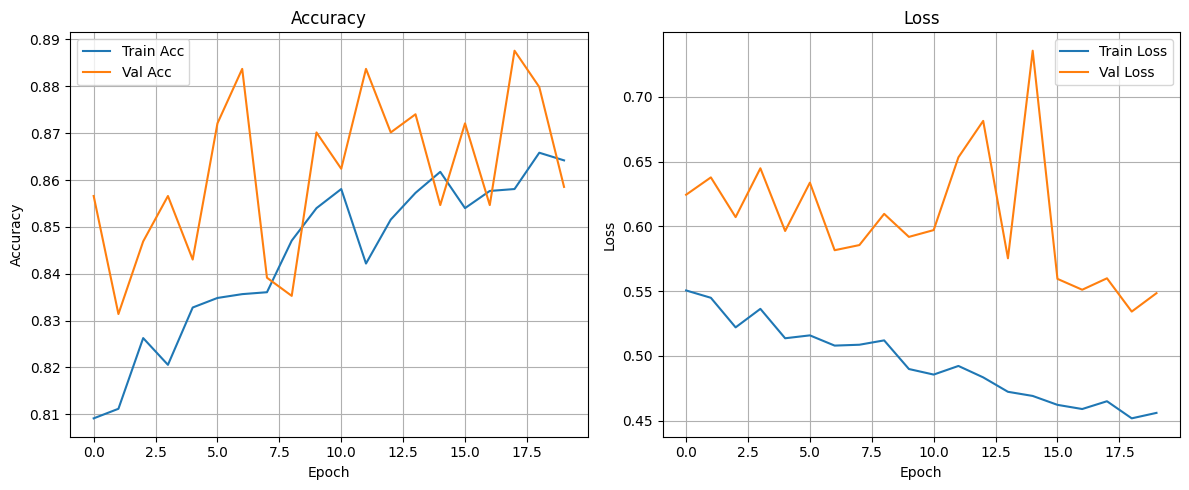


✅ Final improved model saved with oversampling & strong augmentation


In [ ]:
# ========================
# Train model
# ========================
history = model.fit(
    [X_train, f_train], tf.keras.utils.to_categorical(y_train),
    validation_data=([X_test, f_test], tf.keras.utils.to_categorical(y_test)),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights
)

# ========================
# Evaluate
# ========================
pred = np.argmax(model.predict([X_test, f_test]), axis=1)
print("TEST ACCURACY:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred, target_names=le.classes_))

# ========================
# Plot Accuracy & Loss
# ========================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ========================
# Save Model & Encoders
# ========================
model.save("cnn_vit_rbc_test_trainsplit.keras")
pickle.dump(le, open("label_encoder.pkl","wb"))
pickle.dump(scaler, open("scaler.pkl","wb"))
print("\n✅ Final improved model saved with oversampling & strong augmentation")
